The true, in general unknown, funtion we want to estimate is a polynomium of degree $d$ of a variable $x$.
We use as input features polynomium functions applied to $x$, i.e, $(x_1, x_2, \ldots, x_n) = (x, x^2, \ldots, x^n)$. In addition an intercept $b$ is used. In the code, $d$ is represented as pol_order. The idea is to see how the estimations $\hat{y}$ approach better $y$ as $n$ increases from $1$ up to $d$.

To generate $y$, the variable we use the following formula $ y = q (x - r_1) (x - r_2) \ldots (x - r_p)$, such that each $r_i$ represents a root of $y$, and $q$ is a stretching factor that I forced to 1, i.e. $q = 1$. I basicically tried to uniformely distribute these roots over the support of $y$, and added a random factor allowing to create new functions $y$ at each run. I also normalized $y$ to be in the interval $[-1, 1]$ to simplify the visualization.

Finally, concerning the dataset, for the training set we have $m=100$ (represented in the code by q_samples) that are randomly distributed over the domain $[x_{min}, x_{max}]$. For the test set, I simply took q_steps_interval equi-spaced samples from the domain. Note that we consider that noise with a normal distribution $\mathcal{N}(0, \sigma^2)$ affects our measurements.

In [71]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [72]:
def add_noise(x, sigma):
    return np.random.normal(x, scale = sigma)

def create_roots(min_x, max_x, pol_order):
    # Equispaced roots plus some randomness to move a little bit the roots at each run
    roots = np.linspace(min_x, max_x, pol_order) + (max_x - min_x) * np.random.randn(pol_order) / (2 * pol_order)
    # Force the first and last root to be in the interval [min_x; max_x]
    roots[0] = max(min_x, roots[0])
    roots[-1] = min(roots[-1], max_x)
    return roots

def complex_func(x_interval, roots):
    # For each x in the support of y
    for idx in range(len(x_interval)):
        # Evaluate (x_idx - r_1)(x_idx - r_2)...(x_idx - r_pol_order)
        x_interval[idx] = np.prod(x_interval[idx] - roots)
    return x_interval

In the following, y_real represents the values of the real function $y$ evaluated, whereas 

In [73]:
min_x, max_x,  = 0, 1
q_samples, q_steps_interval = 100, 100
pol_order, sigma = 6, 0.1

x_interval = np.linspace(min_x, max_x, q_steps_interval).reshape(-1, 1)
x_samples = min_x + (max_x - min_x) * np.random.rand(q_samples, 1)

# Generate the roots
roots = create_roots(x_interval[0][0], x_interval[-1][0], pol_order)
y_real = complex_func(x_interval.copy(), roots)

# Normalizing the to the interval [0; 1]
factor = np.max(np.abs(y_real))
y_real /= factor 
y_test = add_noise(y_real, sigma)
y_train = add_noise(complex_func(x_samples.copy(), roots)/factor, sigma)

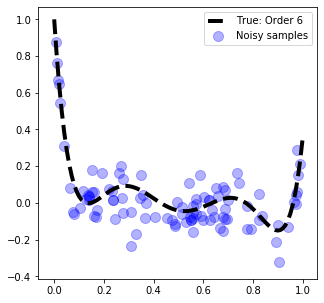

In [74]:
plt.figure(figsize=(5, 5))
plt.plot(x_interval, y_real, 'k--', linewidth = 4,  label = 'True: Order ' + str(pol_order))
plt.scatter(x_samples, y_train, color = 'b', label = 'Noisy samples', s = 100, alpha = 0.3)
plt.legend()

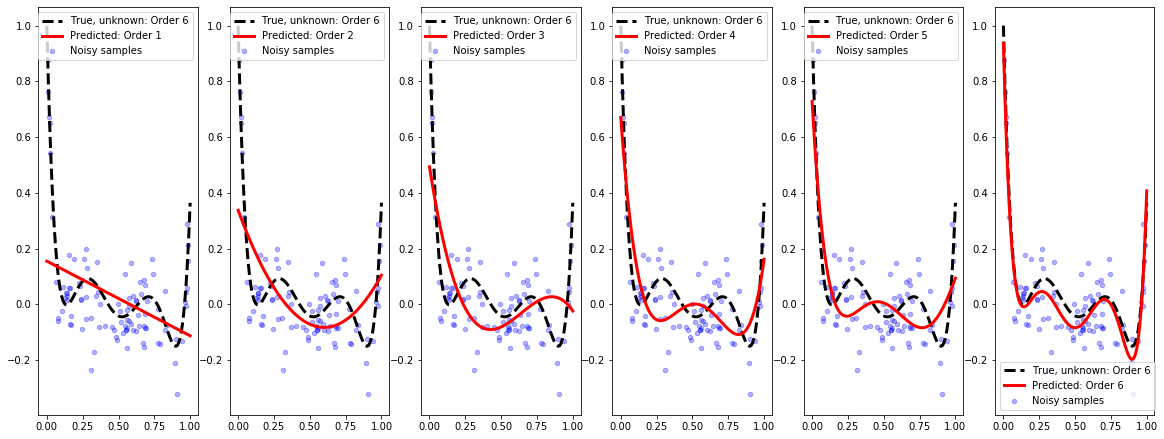

In [75]:
X_test = x_interval
X_train = x_samples
y_pred = np.zeros((q_steps_interval, pol_order))

for j in range(0, pol_order):
    clf = LinearRegression().fit(X_train, y_train)
    y_pred[:, j] = clf.predict(X_test).ravel()
    X_train = np.hstack((X_train, x_samples ** (j + 2)))
    X_test = np.hstack((X_test, x_interval ** (j + 2)))
X_train = X_train[:, :-1]
X_test = X_test[:, :-1]

if pol_order == 1:
    plt.figure(figsize=(5, 5))
    plt.plot(x_interval, y_real, 'k--', linewidth = 3,  label = 'True, unknown: Order ' + str(pol_order))
    plt.scatter(x_samples, y_train, color = 'b', label = 'Noisy samples', s = 20, alpha = 0.3)
    plt.plot(x_interval, y_pred, 'r', linewidth = 3, label = 'Predicted: Order ' + str(1 + q_dim))
    plt.legend()
else:    
    f, ax = plt.subplots(1, pol_order, figsize=(20, 7.5))
    ax = ax.ravel()
    for q_dim in range(pol_order):
        ax[q_dim].plot(x_interval, y_real, 'k--', linewidth = 3,  label = 'True, unknown: Order ' + str(pol_order))
        ax[q_dim].scatter(x_samples, y_train, color = 'b', label = 'Noisy samples', s = 20, alpha = 0.3)
        ax[q_dim].plot(x_interval, y_pred[:, q_dim], 'r', linewidth = 3, label = 'Predicted: Order ' + str(1 + q_dim))
        ax[q_dim].legend()

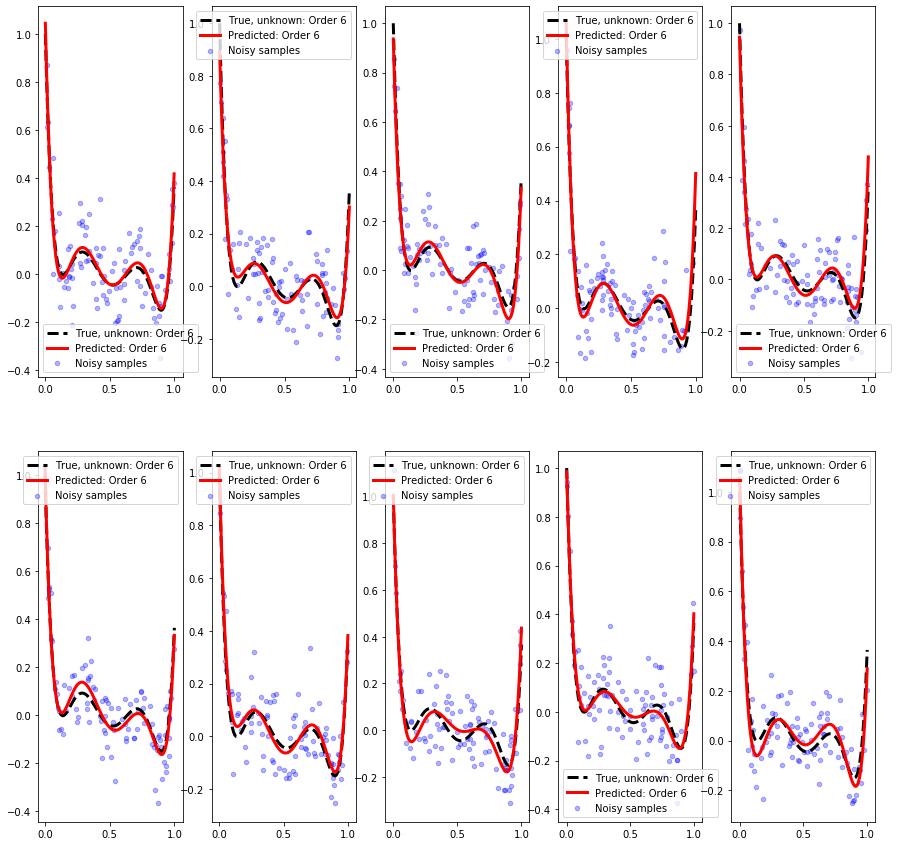

In [76]:
f, ax = plt.subplots(2, 5, figsize=(15, 15))
ax = ax.ravel()
results = []
poly_features = PolynomialFeatures(degree=pol_order, include_bias=False)
for i in range(10):
    x_samples = min_x + (max_x - min_x) * np.random.rand(q_samples, 1)
    y_train = add_noise(complex_func(x_samples.copy(), roots)/factor, sigma)
    X_train = poly_features.fit_transform(x_samples)
    clf.fit(X_train, y_train)
    results.append(clf.predict(X_test))
    ax[i].plot(x_interval, y_real, 'k--', linewidth = 3,  label = 'True, unknown: Order ' + str(pol_order))
    ax[i].scatter(x_samples, y_train, color = 'b', label = 'Noisy samples', s = 20, alpha = 0.3)
    ax[i].plot(x_interval, results[i], 'r', linewidth = 3, label = 'Predicted: Order ' + str(1 + q_dim))
    ax[i].legend()    

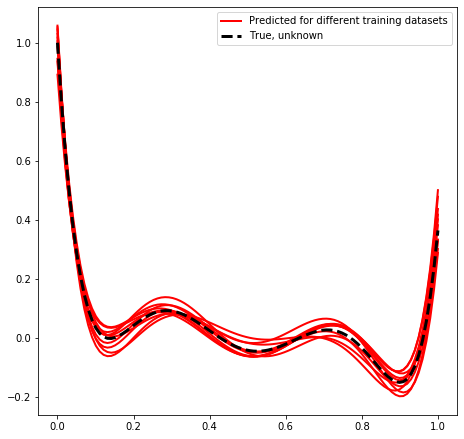

In [77]:
plt.figure(figsize=(7.5, 7.5))
for r in results:
    plt.plot(x_interval, r, 'r', linewidth = 2, label = 'Predicted for different training datasets')
plt.plot(x_interval, y_real, 'k--', linewidth = 3,  label = 'True, unknown')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())